In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2635 files belonging to 10 classes.


In [4]:
#display dataset classes
class_names = dataset.class_names
class_names

['Gauva_diseased',
 'Gauva_healthy',
 'Jamun_diseased',
 'Jamun_healthy',
 'Mango_diseased',
 'Mango_healthy',
 'Pomegranate_diseased',
 'Pomegranate_healthy',
 'Pongamia Pinnata_diseased',
 'Pongamia Pinnata_healthy']

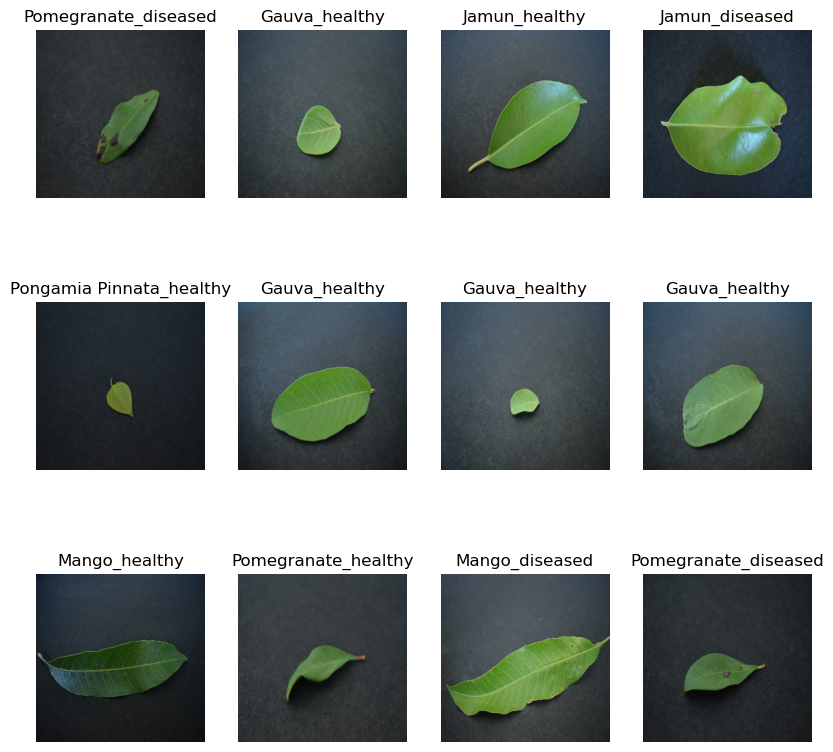

In [5]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
len(dataset)

83

In [7]:
#train dataset length calculation
train_size = 0.8
len(dataset)*train_size

66.4

In [8]:
train_ds = dataset.take(57)
len(train_ds)

57

In [9]:
#test dataset lenght calculation
test_ds = dataset.skip(57)
len(test_ds)

26

In [10]:
#validation dataset length calculation
val_size=0.1
len(dataset)*val_size

8.3

In [11]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [12]:
test_ds = test_ds.skip(7)
len(test_ds)

19

In [13]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(dataset)

83

In [16]:
len(train_ds)

66

In [17]:
len(val_ds)

8

In [18]:
len(test_ds)

9

In [19]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#pre-processing: image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 layers.Rescaling(1./255),
])

In [21]:
normalized_dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))

In [22]:
for images, labels in normalized_dataset:
    for image in images:
        print(image)

tf.Tensor(
[[[0.071178   0.14176625 0.22019762]
  [0.0627451  0.13333334 0.21960786]
  [0.06741729 0.13800552 0.22428004]
  ...
  [0.06689645 0.14532782 0.23944548]
  [0.05777421 0.13620558 0.23032324]
  [0.05671722 0.1351486  0.22926626]]

 [[0.05906863 0.12965687 0.20808825]
  [0.06519608 0.13578433 0.2142157 ]
  [0.08337929 0.15396753 0.23239891]
  ...
  [0.07034314 0.14877452 0.24289218]
  [0.06666667 0.14509805 0.2392157 ]
  [0.05992647 0.13835785 0.2324755 ]]

 [[0.075      0.14558825 0.22401962]
  [0.07044271 0.14103095 0.21946234]
  [0.0752834  0.14587164 0.22430302]
  ...
  [0.07463235 0.15306373 0.24718139]
  [0.071178   0.14960939 0.24372704]
  [0.06714921 0.14558059 0.23969823]]

 ...

 [[0.06752452 0.09889706 0.14203432]
  [0.06676624 0.09421723 0.15696232]
  [0.07058824 0.09803922 0.16078432]
  ...
  [0.05114124 0.07859223 0.14133732]
  [0.0627451  0.09019608 0.15294118]
  [0.0509804  0.07843138 0.14117648]]

 [[0.0674709  0.09492188 0.15766698]
  [0.07316177 0.10061275 0

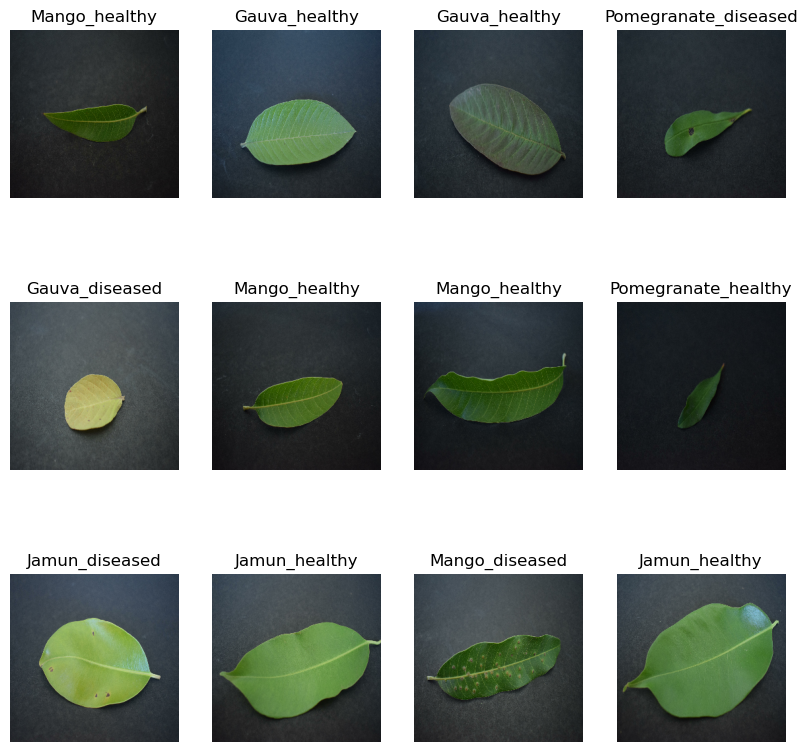

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [24]:
#pre-processing: data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [25]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

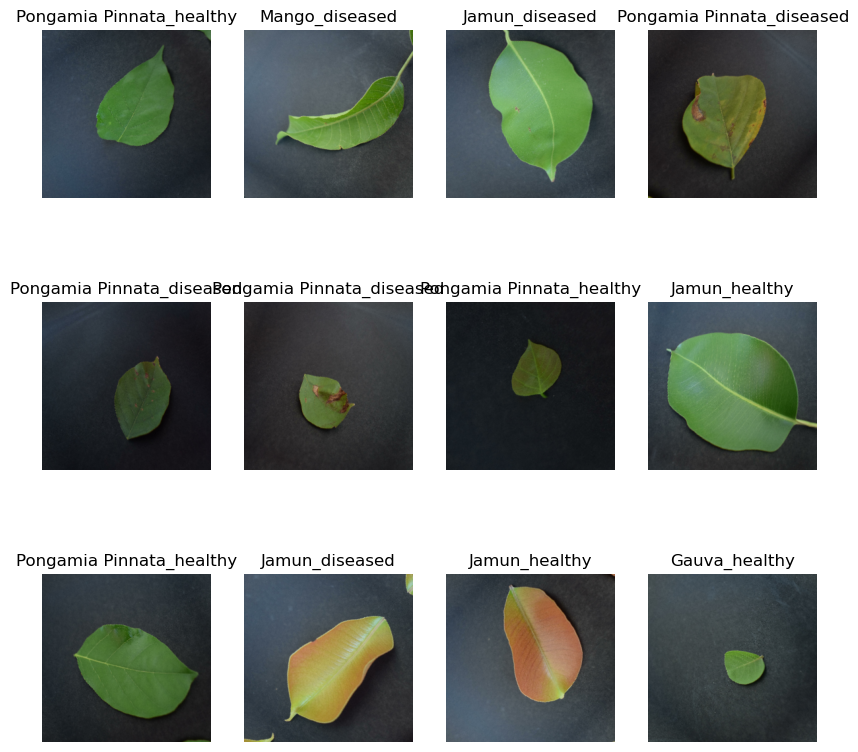

In [26]:
#disable shuffling to see augmentation result

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [27]:
#building CNN model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
totalClasses = 10

model = models.Sequential([
    #feature extraction
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #classification
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(totalClasses, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Hp\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 123008)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,883,370 (30.07 MB)

 Trainable params: 7,883,370 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.2203 - loss: 2.2446 - val_accuracy: 0.5078 - val_loss: 1.3594
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 932ms/step - accuracy: 0.6121 - loss: 1.1597 - val_accuracy: 0.5781 - val_loss: 1.0757
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - accuracy: 0.6905 - loss: 0.8785 - val_accuracy: 0.7656 - val_loss: 0.6693
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 677ms/step - accuracy: 0.7665 - loss: 0.6829 - val_accuracy: 0.7969 - val_loss: 0.7124
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 670ms/step - accuracy: 0.7593 - loss: 0.6834 - val_accuracy: 0.8672 - val_loss: 0.4734
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 671ms/step - accuracy: 0.8076 - loss: 0.5630 - val_accuracy: 0.8438 - val_loss: 0.5219
Epoch 7/30
38/66 ━━━━━━━━━━━━━━━━━━━━ 18s 655ms/step - accuracy: 0.8169 - loss: 0.5458

In [ ]:
model.save('model.h5')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('C:/Users/Hp/Downloads/test image'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from PIL import Image
import imagehash
from pushbullet import Pushbullet
pb = Pushbullet("o.0Hsct9Da1Odrbckq36GnJOWwVDI74kAc")
hash0 = imagehash.average_hash(Image.open('C:/Users/Hp/Downloads/test image/1.jpg')) 
hash1 = imagehash.average_hash(Image.open('C:/Users/Hp/Downloads/test image/7.jpg')) 
cutoff = 2  # maximum bits that could be different between the hashes. 
cutoff1 = 7
diff=hash0 - hash1
if diff < 3:
  print('Plant leaf Healthy')
  push = pb.push_note("Alert", "Plant leaf Healthy")
elif diff > 2 and diff<8 :
  print('Plant leaf unhealthy above 60%')
  push = pb.push_note("Alert", "Plant leaf unhealthy above 60%")
elif diff > 7:
  print('Plant leaf unhealthy above 80%')
  push = pb.push_note("Alert", "Plant leaf unhealthy above 80%")
else:
  print('')
